# Cyberbullying On Social Media

# XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

import imblearn
# print(imblearn.__version__)
from imblearn.over_sampling import SMOTE

# !pip install xgboost

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('labeled_insta_cleaned.csv', encoding = 'utf-8-sig', engine = 'python')

In [3]:
comments = df['tidy_text']
labels = df['label_bullying']

In [4]:
#keep the same random state for reproducibility
RANDOM_STATE = 12
TRAIN_TEST_SPLIT_SIZE = .1
VALIDATION_SPLIT_SIZE = .2

**XGBoost**

Extreme Gradient Boosting (xgboost) is an advanced implementation of the gradient boosting algorithm. It has both linear model solver and tree learning algorithms. Its ability to do parallel computation on a single machine makes it extremely fast. 

Some key benefits of XGBoost are:

- Regularization - helps in reducing overfitting

- Parallel Processing - XGBoost implements parallel processing and is blazingly faster as compared to GBM.

- Handling Missing Values - It has an in-built routine to handle missing values.

- Built-in Cross-Validation - allows user to run a cross-validation at each iteration of the boosting process


For this part I will perform the following steps:
- Evaluate the XGBoost model for the different word embeddings
- Tune the regularization strength parameter with cross-validated grid-search for each type of embeddings
- Check the predictions against the actual values
- Compare the results for the different word embeddings

**Hyperparameter Tuning**

XGBoost has quite a many tuning parameters and sometimes it becomes tricky to properly tune them. I used these guides for ideas on how to tune the model:

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

**Quick note on the method**

In an ideal world, with infinite resources and where time is not an issue, I could run a giant grid search with all the parameters together and find the optimal solution. In fact, I gave it a try: using TFIDF I managed to find the optimal parameters after about 8 hours. For Word2Vec and using the same searh space as here I had to give up after 20 hours. Perhaps it is still doable with really small datasets, but for this dataset (which is by far not the largest), the training time was growing exponentially, and each step in the tuning process was becoming more and more expensive. 

In practice this approach is rarely feasible, so instead I'll go through the parameters one or two at a time. After careful reading, I decided to tune 5 of the hyperparameters that usually have a big impact on the performance. In theory it would be necessary to test all combinations to ensure we find THE optimal solution, but here I will try to find a good enough one by improving the model with a reasonable number of steps.

I somehow wanted to still give it a try using GridSearchCV as well, so I decided to try using a smaller search space. Interestingly enough, although the parameters I found here by manual trials were in the search space, GridSearchCV found different best parameters. Even though the parameters found were different, the results are the same. This tells us that tuning the parameters has little influence on the results, and the quality of the results is mostly influenced by the size and quality of the data set, and there isn't much more that can be done to improve these results.


**Approach for Parameter Tuning**

- Choose a relatively high learning rate. The default learning rate of 0.3 used at this stage. 

- Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.

- Tune the learning rate.

- Finally tune gamma to avoid overfitting (optional).

- Determine the optimum number of trees. XGBoost also has its own cv function which performs cross-validation at each boosting iteration and returns the optimum number of trees required. I will set a very high number of trees (or num_boost_round in XGBoost terminology and rely on early stopping.

**Using XGBoost’s CV**

In order to tune the hyperparameters, I will use the cv function from XGBoost. It allows  to run cross-validation on the training dataset and returns a score (either built-in or customly defined).
It requires the following inputs:
- params: dictionary of parameters.
- dtrain matrix.
- num_boost_round: number of boosting rounds. Here I will use a large number and count on early_stopping_rounds to find the optimal number of rounds before reaching the maximum.
- seed: random seed. It's important to set a seed here, to ensure we are using the same folds for each step so we can properly compare the scores with different parameters.
- nfold: the number of folds to use for cross-validation. Setting this to 5, same as for the other classifiers.
- metrics: the metrics to use to evaluate the model. For this part I have defined a custom F1 score metric, since XGBoost does not have one natively, and I wanted to compare to other classifiers using the same metric.


**A note about num_boost_round and early_stopping_rounds**

XGBoost is a gradient boosting method, as such it adds trees in every iteration to improve the prediction accuracy (performance). 

The prediction performance increases when you add more and more trees until it starts to overfit, at which point the it will start to decrease. So we need to find that optimum number of trees. It is basically impossible to guess this number, and this is what XGBoost.cv is for. It partitions the training data into two subsets. The first subset is used to train XGBoost, the second is used as a validation set. After each iteration (which adds an additional tree) XGBoost calculates the new validation error. With that XGBoost is able to detect when it starts to overfit (when the chosen evaluation metric starts to either increase (loss), or decrease (our custom F1 score)). This will give us the optimal number of trees for a given set of hyperparameters.

The num_boost_rounds (number of trees) parameter is not part of the PARAMETERS dictionary, but it is also a tunable parameter. num_boost_round corresponds to the number of boosting rounds or trees to build. Its optimal value highly depends on the other parameters. This means it should be re-tuned each time we update a parameter. I could do this by tuning it together with all parameters in the grid-search, but it requires a lot of computational effort. Fortunately XGBoost provides a nice way to find the best number of rounds while training. Since trees are built sequentially, instead of fixing the number of rounds at the beginning, we can test our model at each step and see if adding a new tree/boost round improves performance. If the performance hasn’t improved for a specific number of rounds (as defined by the variable early_stopping_round), we stop the training and keep the best number of boosting rounds. 


I've decided here to use the XGBoost algorithm directly for tuning (mostly because it makes cross validation easy), there is also a scikit learn wrapper around XGBoost called XGBRegressor. The XGBoost algorithm is more customizeable, but the scikit learn wrapper plays more nicely with pipelines (and doesn't need DMatrix input).

***

**Utility Functions**

***

In [5]:
def custom_f1_score(preds, d_train):
    labels = d_train.get_label().astype(np.int)
    preds = (preds >= 0.5).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

In [6]:
# setup color scheme and standard figure size for all figures
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = metrics.confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [8]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth=2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth=2, color=colors[6], linestyle=':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [9]:
def init_params():
#     Initialize with default parameters
    PARAMETERS['max_depth'] = 6
    PARAMETERS['min_child_weight'] = 1
    PARAMETERS['eta'] = .3
    PARAMETERS['subsample'] = 1
    PARAMETERS['colsample_bytree'] = 1
    return PARAMETERS

In [10]:
def cross_validation(PARAMETERS, d_train):
    cv_results = xgb.cv(PARAMETERS,
        d_train,
        feval = custom_f1_score,
        num_boost_round = NUM_BOOST_ROUNDS,
        maximize = True,
        seed = RANDOM_SEED,
        nfold = 5,
        early_stopping_rounds = EARLY_STOPPING_ROUNDS
    )
    return cv_results

***

**TF-IDF**

***

**Prepare the data set and DMatrices**

**Notice the difference here with respect to the 05.1. XGBoost notebook. Here I will use the imbalanced TF-IDF features to see if this improves the performance of the model.**

In [11]:
train_tfidf_features = np.load('train_dataset_unbalanced_tfidf_features.npy', allow_pickle=True)
train_tfidf_labels = np.load('train_dataset_unbalanced_tfidf_labels.npy', allow_pickle=True)

In [12]:
test_tfidf_features = np.load('test_dataset_tfidf_features.npy', allow_pickle=True)
test_tfidf_labels = np.load('test_dataset_tfidf_labels.npy', allow_pickle=True)

In [13]:
val_tfidf_features = np.load('val_dataset_tfidf_features.npy', allow_pickle=True)
val_tfidf_labels = np.load('val_dataset_tfidf_labels.npy', allow_pickle=True)

In [14]:
# Create X/y arrays
x_train_tfidf = train_tfidf_features.item()
y_train_tfidf = train_tfidf_labels

print('x:', x_train_tfidf.shape, x_train_tfidf.dtype)
print('y:', y_train_tfidf.shape, y_train_tfidf.dtype)

x: (7943, 1000) float64
y: (7943,) int64


In [15]:
# Create X/y arrays
x_test_tfidf = test_tfidf_features.item()
y_test_tfidf = test_tfidf_labels

print('x:', x_test_tfidf.shape, x_test_tfidf.dtype)
print('y:', y_test_tfidf.shape, y_test_tfidf.dtype)

x: (1104, 1000) float64
y: (1104,) int64


In [16]:
# Create X/y arrays
x_val_tfidf = val_tfidf_features.item()
y_val_tfidf = val_tfidf_labels

print('x:', x_val_tfidf.shape, x_val_tfidf.dtype)
print('y:', y_val_tfidf.shape, y_val_tfidf.dtype)

x: (1986, 1000) float64
y: (1986,) int64


Instead of numpy arrays or pandas data frames, XGBoost uses DMatrices. A DMatrix can contain both the features and the target. The data is already loaded into arrays, so I can use them to create the DMatrix. 

In [17]:
# A DMatrix can contain both the features and the target.
d_train_tfidf = xgb.DMatrix(x_train_tfidf, label = y_train_tfidf) 
d_test_tfidf = xgb.DMatrix(x_test_tfidf, label = y_test_tfidf)
d_val_tfidf = xgb.DMatrix(x_val_tfidf, label = y_val_tfidf)
watchlist_tfidf = [(d_train_tfidf, 'train'), (d_val_tfidf, 'val')]

In [18]:
# Initialize with default parameters
PARAMETERS = {
     'objective':'binary:logistic',
     'max_depth':6,
     'min_child_weight': 1,
     'eta':.3,
     'subsample': 1,
     'colsample_bytree': 1
  }

In [19]:
RANDOM_SEED = 12
NUM_BOOST_ROUNDS = 1000
EARLY_STOPPING_ROUNDS = 20

**Tune max_depth and min_child_weight** 

I'll tune these concurrently using a basic grid search, meaning I'll test all combinations of the two variables in a certain range. Whichever combination has the best cross validation score, will be set as values for the next round.


- max_depth is the largest depth allowed on any decision tree in the ensemble, where tree depth is the number of nodes from the root down to the farthest away leaf. Larger max_depth values allow for more complex trees, which means a larger chance of capturing complicated features but also a larger chance of overfitting.
- min_child_weight is a regularization factor that changes how often tree nodes split in tree creation. 

In [20]:
# Tune max_depth and min_child_weight
gs_space = [
    (max_depth, min_child_weight)
    for max_depth in range(3,10,2)
        for min_child_weight in range(1,6,2)
]
max_f1 = 0. # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gs_space:
    print("Performing cross validation for parameters max_depth = {}, min_child_weight = {}".format(max_depth, min_child_weight))
    
    # Update parameters
    PARAMETERS['max_depth'] = max_depth
    PARAMETERS['min_child_weight'] = min_child_weight
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_tfidf)
    
    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth, min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters max_depth = 3, min_child_weight = 1
	F1 Score 0.35540399999999994 reached after 313 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 3
	F1 Score 0.35531480000000004 reached after 316 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 5
	F1 Score 0.3733664 reached after 338 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 1
	F1 Score 0.352269 reached after 185 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 3
	F1 Score 0.3458536 reached after 135 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 5
	F1 Score 0.37391979999999997 reached after 207 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 1
	F1 Score 0.3714034 reached after 176 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 3
	F1 Score 0.378486200000

In [21]:
# Update max_depth and min_child_weight parameters.
PARAMETERS['max_depth'] = best_params[0]
PARAMETERS['min_child_weight'] = best_params[1]

**Tune subsample and colsample**

- subsample is the fraction of datapoints (rows of the training data) to sample at each round (each tree), with 0 meaning no rows are sampled and 1 meaning all rows are sampled. The higher the value, the more likely to overfit the data.
- colsample_bytree is the fraction of features (columns of the training data) to sample at each round (each tree), with 0 meaning no columns are sampled and 1 meaning all columns are sampled. The higher the value, the more likely to overfit the data.

In [22]:
# Tuning subsample and colsample
gs_space = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(5,10)]
    for colsample_bytree in [i/10. for i in range(5,10)] 
]
max_f1 = 0. 
best_params = None 
for subsample, colsample_bytree in gs_space:
    print("Performing cross validation for parameters subsample = {}, colsample_bytree = {}".format(subsample, colsample_bytree))
    
    # Update parameters
    PARAMETERS['colsample_bytree'] = colsample_bytree
    PARAMETERS['subsample'] = subsample
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_tfidf)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample_bytree) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.5
	F1 Score 0.3778256 reached after 88 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.6
	F1 Score 0.3612684 reached after 97 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.7
	F1 Score 0.3582862 reached after 82 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.8
	F1 Score 0.36965480000000006 reached after 103 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.9
	F1 Score 0.357854 reached after 61 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.5
	F1 Score 0.3439574 reached after 62 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.6
	F1 Score 0.3668634 reached after 106 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.7
	F1 Score 0.37204

In [23]:
# Update subsample and colsample_bytree
PARAMETERS['subsample'] = best_params[0]
PARAMETERS['colsample_bytree'] = best_params[1]

**Tune eta**

Eta in XGBoost works the same way as a learning rate, in the sense that it controls how quickly each step changes. The smaller the eta, the smaller each step, which means the algorithm will likely take more steps to converge.

In [24]:
# Tune the learning rate.
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("Performing cross validation for parameter eta = {}".format(eta))
    
    # Update ETA
    PARAMETERS['eta'] = eta
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_tfidf)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

Performing cross validation for parameter eta = 0.3
	F1 Score 0.38573620000000003 reached after 209 rounds
Performing cross validation for parameter eta = 0.2
	F1 Score 0.37864020000000004 reached after 208 rounds
Performing cross validation for parameter eta = 0.1
	F1 Score 0.35652500000000004 reached after 241 rounds
Performing cross validation for parameter eta = 0.05
	F1 Score 0.2565382 reached after 53 rounds
Performing cross validation for parameter eta = 0.01
	F1 Score 0.23659060000000004 reached after 11 rounds
Performing cross validation for parameter eta = 0.005
	F1 Score 0.23765260000000002 reached after 11 rounds
Best params: 0.3, F1 Score: 0.38573620000000003


In [25]:
# Update eta.
PARAMETERS['eta'] = best_params

Let’s have a look at the final list of tuned parameters.

In [26]:
PARAMETERS

{'objective': 'binary:logistic',
 'max_depth': 7,
 'min_child_weight': 5,
 'eta': 0.3,
 'subsample': 0.9,
 'colsample_bytree': 0.7}

Finally I can now use these tuned parameters in the xgboost model. I will set a very high num_boost_round and rely on early stopping to stop the model if its performance doesn’t improve in 20 rounds.

In [27]:
xgb_model = xgb.train(
    PARAMETERS,
    d_train_tfidf,
    feval = custom_f1_score,
    num_boost_round = NUM_BOOST_ROUNDS,
    maximize = True,
    evals = watchlist_tfidf,
    early_stopping_rounds = EARLY_STOPPING_ROUNDS, 
    verbose_eval = True)

[0]	train-error:0.25746	val-error:0.26032	train-f1_score:0.26781	val-f1_score:0.26667
Multiple eval metrics have been passed: 'val-f1_score' will be used for early stopping.

Will train until val-f1_score hasn't improved in 20 rounds.
[1]	train-error:0.25267	val-error:0.25932	train-f1_score:0.24860	val-f1_score:0.23019
[2]	train-error:0.24902	val-error:0.25629	train-f1_score:0.26139	val-f1_score:0.24815
[3]	train-error:0.24500	val-error:0.25831	train-f1_score:0.29185	val-f1_score:0.26187
[4]	train-error:0.24437	val-error:0.26083	train-f1_score:0.29648	val-f1_score:0.25575
[5]	train-error:0.24323	val-error:0.25730	train-f1_score:0.29127	val-f1_score:0.25183
[6]	train-error:0.23983	val-error:0.25932	train-f1_score:0.30702	val-f1_score:0.25685
[7]	train-error:0.23933	val-error:0.25982	train-f1_score:0.30544	val-f1_score:0.25000
[8]	train-error:0.23429	val-error:0.26083	train-f1_score:0.34356	val-f1_score:0.26836
[9]	train-error:0.23341	val-error:0.25932	train-f1_score:0.34672	val-f1_score

[93]	train-error:0.18469	val-error:0.26183	train-f1_score:0.56815	val-f1_score:0.37198
[94]	train-error:0.18494	val-error:0.26133	train-f1_score:0.56781	val-f1_score:0.37545
[95]	train-error:0.18469	val-error:0.26183	train-f1_score:0.56840	val-f1_score:0.37349
[96]	train-error:0.18444	val-error:0.26234	train-f1_score:0.56950	val-f1_score:0.37305
[97]	train-error:0.18368	val-error:0.26435	train-f1_score:0.57202	val-f1_score:0.37276
[98]	train-error:0.18368	val-error:0.26284	train-f1_score:0.57352	val-f1_score:0.37857
[99]	train-error:0.18318	val-error:0.26234	train-f1_score:0.57518	val-f1_score:0.38050
[100]	train-error:0.18305	val-error:0.26083	train-f1_score:0.57560	val-f1_score:0.38186
[101]	train-error:0.18305	val-error:0.26234	train-f1_score:0.57609	val-f1_score:0.37902
[102]	train-error:0.18318	val-error:0.26234	train-f1_score:0.57568	val-f1_score:0.37902
[103]	train-error:0.18268	val-error:0.26385	train-f1_score:0.57635	val-f1_score:0.37321
[104]	train-error:0.18268	val-error:0.2

In [28]:
# XGBoost returns probabilities by default.
y_probas_train_tfidf = xgb_model.predict(d_train_tfidf)
y_probas_test_tfidf = xgb_model.predict(d_test_tfidf)

In [29]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf)

True Negatives:  729
False Positives:  56
False Negatives:  220
True Positives:  99


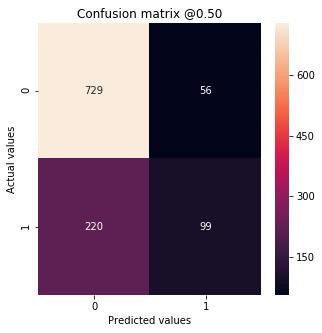

In [30]:
plot_cfm(y_test_tfidf, y_probas_test_tfidf)

In [31]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       785
           1       0.64      0.31      0.42       319

    accuracy                           0.75      1104
   macro avg       0.70      0.62      0.63      1104
weighted avg       0.73      0.75      0.72      1104



This is the only model where weighted precision and recall across both classes come closer to the values reported in the orginal paper, at 73% precision and 75% recall. 

In [32]:
f1_tfidf = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('TFDIF F1: %.2f' % f1_tfidf)

TFDIF F1: 0.72


In [33]:
auc_tfidf = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('TFIDF AUC: %.2f' % auc_tfidf)

TFIDF AUC: 0.72


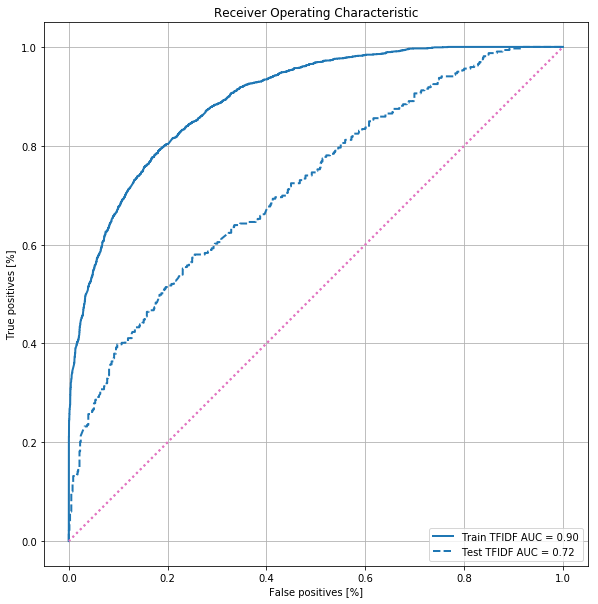

In [34]:
plot_roc("Train TFIDF", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test TFIDF", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

Interestingly enough, compared to the other models where the train and test curves followed a similar curve, XGBoost seems to achieve an extremely good ROC AUC curve for the training data, but fails to generalize for the test data. 

***

**Word2Vec**

***

Apply the same steps for the Word2Vec vectors.

**Prepare the datasets**

Preparing the datasets here also needs to account for the train-validation-test split, as well as applying SMOTE to the training data only.

In [35]:
w2v_features = np.load('w2v_features.npy', allow_pickle=True)

In [36]:
# Create X/y arrays
comments_w2v = w2v_features
labels_w2v = labels
print('x:', comments_w2v.shape, comments_w2v.dtype) 
print('y:', labels_w2v.shape, labels_w2v.dtype)

x: (11033, 100) float64
y: (11033,) int64


In [37]:
x_train_val_w2v, x_test_w2v, y_train_val_w2v, y_test_w2v = train_test_split(comments_w2v, labels_w2v,
                                                  test_size = TRAIN_TEST_SPLIT_SIZE, stratify = labels_w2v,
                                                  random_state = RANDOM_STATE)

In [38]:
x_train_w2v, x_val_w2v, y_train_w2v, y_val_w2v = train_test_split(x_train_val_w2v, y_train_val_w2v,
                                                  test_size = VALIDATION_SPLIT_SIZE, stratify = y_train_val_w2v,
                                                  random_state = RANDOM_STATE)

In [39]:
# A DMatrix can contain both the features and the target.
d_train_w2v = xgb.DMatrix(x_train_w2v, label = y_train_w2v) 
d_test_w2v = xgb.DMatrix(x_test_w2v, label = y_test_w2v)
d_val_w2v = xgb.DMatrix(x_val_w2v, label = y_val_w2v)
watchlist_w2v = [(d_train_w2v, 'train'), (d_val_w2v, 'val')]

In [40]:
# initialize parameters to default values
init_params()

{'objective': 'binary:logistic',
 'max_depth': 6,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1}

In [41]:
# Tune max_depth and min_child_weight
gs_space = [
    (max_depth, min_child_weight)
    for max_depth in range(3,10,2)
        for min_child_weight in range(1,6,2)
]
max_f1 = 0. # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gs_space:
    print("Performing cross validation for parameters max_depth = {}, min_child_weight = {}".format(max_depth, min_child_weight))
    
    # Update  parameters
    PARAMETERS['max_depth'] = max_depth
    PARAMETERS['min_child_weight'] = min_child_weight
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_w2v)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth, min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters max_depth = 3, min_child_weight = 1
	F1 Score 0.357265 reached after 0 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 3
	F1 Score 0.357265 reached after 0 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 5
	F1 Score 0.357265 reached after 0 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 1
	F1 Score 0.3919796 reached after 28 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 3
	F1 Score 0.4056762 reached after 40 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 5
	F1 Score 0.41466899999999995 reached after 51 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 1
	F1 Score 0.4009314 reached after 56 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 3
	F1 Score 0.39246980000000004 reached after 9 rounds
Per

In [42]:
# Update max_depth and min_child_weight parameters.
PARAMETERS['max_depth'] = best_params[0]
PARAMETERS['min_child_weight'] = best_params[1]

In [43]:
# Tune subsample and colsample
gs_space = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(5,10)]
    for colsample_bytree in [i/10. for i in range(5,10)] 
]
max_f1 = 0. 
best_params = None 
for subsample, colsample_bytree in gs_space:
    print("Performing cross validation for parameters subsample = {}, colsample_bytree = {}".format(subsample, colsample_bytree))
    
    # Update parameters
    PARAMETERS['colsample_bytree'] = colsample_bytree
    PARAMETERS['subsample'] = subsample

    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_w2v)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample_bytree) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.5
	F1 Score 0.397432 reached after 45 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.6
	F1 Score 0.4070882 reached after 42 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.7
	F1 Score 0.398482 reached after 42 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.8
	F1 Score 0.40418380000000004 reached after 33 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.9
	F1 Score 0.4146832 reached after 86 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.5
	F1 Score 0.40379319999999996 reached after 39 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.6
	F1 Score 0.40724879999999997 reached after 46 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.7


In [44]:
# Update subsample and colsample_bytree
PARAMETERS['subsample'] = best_params[0]
PARAMETERS['colsample_bytree'] = best_params[1]

In [45]:
# Tune the learning rate.
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("Performing cross validation for parameter eta = {}".format(eta))
    
    # Update ETA
    PARAMETERS['eta'] = eta

    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_w2v)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

Performing cross validation for parameter eta = 0.3
	F1 Score 0.4338316 reached after 105 rounds
Performing cross validation for parameter eta = 0.2
	F1 Score 0.40244360000000007 reached after 76 rounds
Performing cross validation for parameter eta = 0.1
	F1 Score 0.4015974 reached after 143 rounds
Performing cross validation for parameter eta = 0.05
	F1 Score 0.3178374 reached after 0 rounds
Performing cross validation for parameter eta = 0.01
	F1 Score 0.3178374 reached after 0 rounds
Performing cross validation for parameter eta = 0.005
	F1 Score 0.3178374 reached after 0 rounds
Best params: 0.3, F1 Score: 0.4338316


In [46]:
# Update eta.
PARAMETERS['eta'] = best_params

In [47]:
PARAMETERS

{'objective': 'binary:logistic',
 'max_depth': 5,
 'min_child_weight': 5,
 'eta': 0.3,
 'subsample': 0.7,
 'colsample_bytree': 0.8}

In [48]:
xgb_model = xgb.train(
    PARAMETERS,
    d_train_w2v,
    feval = custom_f1_score,
    num_boost_round = NUM_BOOST_ROUNDS,
    maximize = True,
    evals = watchlist_w2v,
    early_stopping_rounds = EARLY_STOPPING_ROUNDS, 
    verbose_eval = True)

[0]	train-error:0.26325	val-error:0.27643	train-f1_score:0.35002	val-f1_score:0.31801
Multiple eval metrics have been passed: 'val-f1_score' will be used for early stopping.

Will train until val-f1_score hasn't improved in 20 rounds.
[1]	train-error:0.24840	val-error:0.26989	train-f1_score:0.39939	val-f1_score:0.35422
[2]	train-error:0.24575	val-error:0.25881	train-f1_score:0.38885	val-f1_score:0.34772
[3]	train-error:0.23996	val-error:0.25831	train-f1_score:0.40512	val-f1_score:0.35955
[4]	train-error:0.23505	val-error:0.25680	train-f1_score:0.42607	val-f1_score:0.36567
[5]	train-error:0.23115	val-error:0.25730	train-f1_score:0.43228	val-f1_score:0.37146
[6]	train-error:0.22964	val-error:0.25629	train-f1_score:0.44118	val-f1_score:0.37083
[7]	train-error:0.22548	val-error:0.25227	train-f1_score:0.45809	val-f1_score:0.39125
[8]	train-error:0.22246	val-error:0.26032	train-f1_score:0.46793	val-f1_score:0.37333
[9]	train-error:0.21755	val-error:0.25478	train-f1_score:0.48936	val-f1_score

In [49]:
y_probas_train_w2v = xgb_model.predict(d_train_w2v)
y_probas_test_w2v = xgb_model.predict(d_test_w2v)

In [50]:
y_pred_test_w2v = np.round(y_probas_test_w2v)

True Negatives:  689
False Positives:  96
False Negatives:  212
True Positives:  107


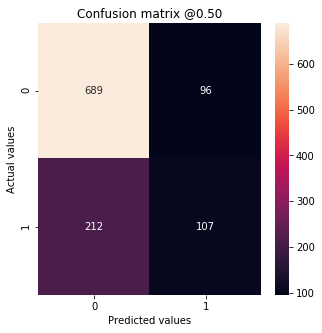

In [51]:
plot_cfm(y_test_w2v, y_probas_test_w2v)

In [52]:
print(classification_report(y_test_w2v, y_pred_test_w2v))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82       785
           1       0.53      0.34      0.41       319

    accuracy                           0.72      1104
   macro avg       0.65      0.61      0.61      1104
weighted avg       0.70      0.72      0.70      1104



In [53]:
f1_w2v = f1_score(y_test_w2v, y_pred_test_w2v, average = 'weighted')
print('W2V F1: %.2f' % f1_w2v)

W2V F1: 0.70


In [54]:
auc_w2v = roc_auc_score(y_test_w2v, y_probas_test_w2v)
print('W2V AUC: %.2f' % auc_w2v)

W2V AUC: 0.67


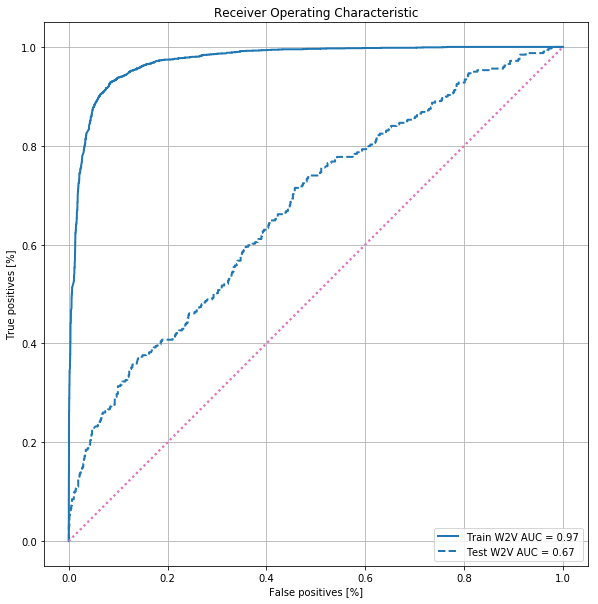

In [55]:
plot_roc("Train W2V", y_train_w2v, y_probas_train_w2v, color = colors[0])
plot_roc("Test W2V", y_test_w2v, y_probas_test_w2v, color = colors[0], linestyle='--')

Here we notice a similar behaviour as for the TF-IDF features: XGBoost seems to achieve a perfect ROC AUC curve for the training data, but fails to generalize for the test data.

***

**Glove/FastText Embeddings**

***

In [56]:
gft_features = np.load('gloveft_features.npy', allow_pickle=True)

In [57]:
# Create X/y arrays
comments_gft = gft_features
labels_gft = labels
print('x:', comments_gft.shape, comments_gft.dtype) 
print('y:', labels_gft.shape, labels_gft.dtype)

x: (11033, 100) float64
y: (11033,) int64


In [58]:
x_train_val_gft, x_test_gft, y_train_val_gft, y_test_gft = train_test_split(comments_gft, labels_gft,
                                                  test_size = TRAIN_TEST_SPLIT_SIZE, stratify = labels_gft,
                                                  random_state = RANDOM_STATE)

In [59]:
x_train_gft, x_val_gft, y_train_gft, y_val_gft = train_test_split(x_train_val_gft, y_train_val_gft,
                                                  test_size = VALIDATION_SPLIT_SIZE, stratify = y_train_val_gft,
                                                  random_state = RANDOM_STATE)

In [60]:
# A DMatrix can contain both the features and the target.
d_train_gft = xgb.DMatrix(x_train_gft, label = y_train_gft) 
d_test_gft = xgb.DMatrix(x_test_gft, label = y_test_gft)
d_val_gft = xgb.DMatrix(x_val_gft, label = y_val_gft)
watchlist_gft = [(d_train_gft, 'train'), (d_val_gft, 'val')]

In [61]:
# initialize parameters to default values
init_params()

{'objective': 'binary:logistic',
 'max_depth': 6,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1}

In [62]:
# Tune max_depth and min_child_weight
gs_space = [
    (max_depth, min_child_weight)
    for max_depth in range(3,10,2)
        for min_child_weight in range(1,6,2)
]
max_f1 = 0. # initializing with 0 
best_params = None 
for max_depth, min_child_weight in gs_space:
    print("Performing cross validation for parameters max_depth = {}, min_child_weight = {}".format(max_depth, min_child_weight))
    
    # Update parameters
    PARAMETERS['max_depth'] = max_depth
    PARAMETERS['min_child_weight'] = min_child_weight

    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_gft)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth, min_child_weight) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters max_depth = 3, min_child_weight = 1
	F1 Score 0.3372966 reached after 0 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 3
	F1 Score 0.3373845999999999 reached after 0 rounds
Performing cross validation for parameters max_depth = 3, min_child_weight = 5
	F1 Score 0.33705379999999996 reached after 0 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 1
	F1 Score 0.3933238 reached after 29 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 3
	F1 Score 0.39621199999999995 reached after 71 rounds
Performing cross validation for parameters max_depth = 5, min_child_weight = 5
	F1 Score 0.3979212 reached after 63 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 1
	F1 Score 0.39862840000000005 reached after 20 rounds
Performing cross validation for parameters max_depth = 7, min_child_weight = 3
	F1 Score 0.393186600000

In [63]:
# Update max_depth and min_child_weight parameters.
PARAMETERS['max_depth'] = best_params[0]
PARAMETERS['min_child_weight'] = best_params[1]

In [64]:
# Tune subsample and colsample
gs_space = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(5,10)]
    for colsample_bytree in [i/10. for i in range(5,10)]
]
max_f1 = 0. 
best_params = None 
for subsample, colsample_bytree in gs_space:
    print("Performing cross validation for parameters subsample = {}, colsample_bytree = {}".format(subsample, colsample_bytree))
    
    # Update parameters
    PARAMETERS['colsample_bytree'] = colsample_bytree
    PARAMETERS['subsample'] = subsample
    
    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_gft)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample_bytree) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.5
	F1 Score 0.4030028 reached after 35 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.6
	F1 Score 0.4046684 reached after 64 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.7
	F1 Score 0.40156220000000004 reached after 27 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.8
	F1 Score 0.40338139999999995 reached after 44 rounds
Performing cross validation for parameters subsample = 0.5, colsample_bytree = 0.9
	F1 Score 0.3962852 reached after 32 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.5
	F1 Score 0.39233700000000005 reached after 40 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.6
	F1 Score 0.4014828 reached after 32 rounds
Performing cross validation for parameters subsample = 0.6, colsample_bytree = 0.

In [65]:
# Update subsample and colsample_bytree
PARAMETERS['subsample'] = best_params[0]
PARAMETERS['colsample_bytree'] = best_params[1]

In [66]:
# Tune the learning rate.
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("Performing cross validation for parameter eta = {}".format(eta))
    
    # Update ETA
    PARAMETERS['eta'] = eta

    # Run cross validation
    cv_results = cross_validation(PARAMETERS, d_train_gft)

    # Find best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = np.argmax(cv_results['test-f1_score-mean'])    
    print("\tF1 Score {} reached after {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

Performing cross validation for parameter eta = 0.3
	F1 Score 0.40966500000000006 reached after 62 rounds
Performing cross validation for parameter eta = 0.2
	F1 Score 0.3873648 reached after 60 rounds
Performing cross validation for parameter eta = 0.1
	F1 Score 0.359674 reached after 0 rounds
Performing cross validation for parameter eta = 0.05
	F1 Score 0.359674 reached after 0 rounds
Performing cross validation for parameter eta = 0.01
	F1 Score 0.359674 reached after 0 rounds
Performing cross validation for parameter eta = 0.005
	F1 Score 0.359674 reached after 0 rounds
Best params: 0.3, F1 Score: 0.40966500000000006


In [67]:
# Update eta.
PARAMETERS['eta'] = best_params

In [68]:
PARAMETERS

{'objective': 'binary:logistic',
 'max_depth': 7,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 0.7,
 'colsample_bytree': 0.5}

In [69]:
xgb_model = xgb.train(
    PARAMETERS,
    d_train_gft,
    feval = custom_f1_score,
    num_boost_round = NUM_BOOST_ROUNDS,
    maximize = True,
    evals = watchlist_gft,
    early_stopping_rounds = EARLY_STOPPING_ROUNDS, 
    verbose_eval = True)

[0]	train-error:0.23794	val-error:0.28751	train-f1_score:0.44386	val-f1_score:0.34783
Multiple eval metrics have been passed: 'val-f1_score' will be used for early stopping.

Will train until val-f1_score hasn't improved in 20 rounds.
[1]	train-error:0.20949	val-error:0.28097	train-f1_score:0.53311	val-f1_score:0.37584
[2]	train-error:0.20055	val-error:0.27946	train-f1_score:0.54834	val-f1_score:0.36280
[3]	train-error:0.19099	val-error:0.27593	train-f1_score:0.56471	val-f1_score:0.35981
[4]	train-error:0.18419	val-error:0.27140	train-f1_score:0.58116	val-f1_score:0.36364
[5]	train-error:0.17323	val-error:0.27090	train-f1_score:0.61042	val-f1_score:0.37296
[6]	train-error:0.16996	val-error:0.27090	train-f1_score:0.62248	val-f1_score:0.38303
[7]	train-error:0.16039	val-error:0.26737	train-f1_score:0.64846	val-f1_score:0.39314
[8]	train-error:0.15334	val-error:0.26385	train-f1_score:0.66776	val-f1_score:0.39211
[9]	train-error:0.14579	val-error:0.27039	train-f1_score:0.68652	val-f1_score

In [70]:
y_probas_train_gft = xgb_model.predict(d_train_gft)
y_probas_test_gft = xgb_model.predict(d_test_gft)

In [71]:
y_pred_test_gft = np.round(y_probas_test_gft)

True Negatives:  684
False Positives:  101
False Negatives:  216
True Positives:  103


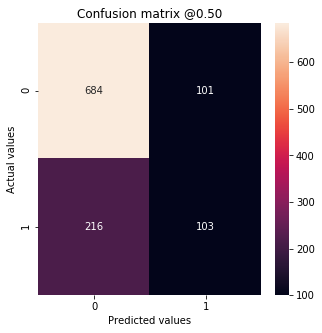

In [72]:
plot_cfm(y_test_gft, y_probas_test_gft)

In [73]:
print(classification_report(y_test_gft, y_pred_test_gft))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       785
           1       0.50      0.32      0.39       319

    accuracy                           0.71      1104
   macro avg       0.63      0.60      0.60      1104
weighted avg       0.69      0.71      0.69      1104



In [74]:
f1_gft = f1_score(y_test_gft, y_pred_test_gft, average = 'weighted')
print('Glove/FastText F1: %.2f' % f1_gft)

Glove/FastText F1: 0.69


In [75]:
auc_gft = roc_auc_score(y_test_gft, y_probas_test_gft)
print('Glove/FastText AUC: %.2f' % auc_gft)

Glove/FastText AUC: 0.65


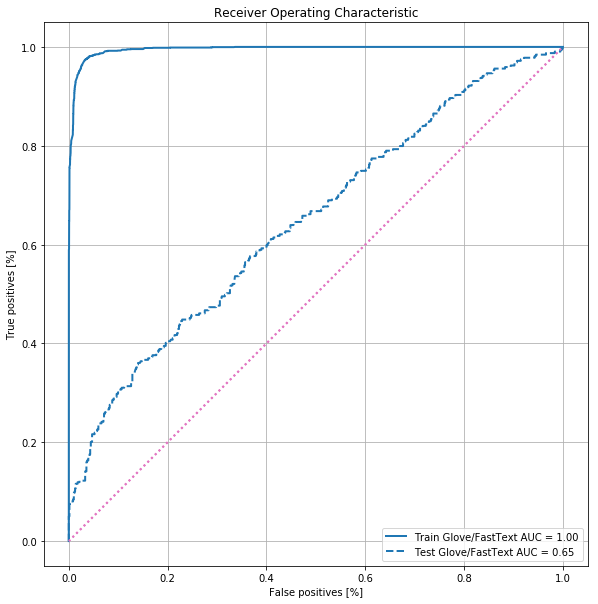

In [76]:
plot_roc("Train Glove/FastText", y_train_gft, y_probas_train_gft, color = colors[0])
plot_roc("Test Glove/FastText", y_test_gft, y_probas_test_gft, color = colors[0], linestyle = '--')

***

**Summary**

***

In [77]:
# !pip install tabletext
import tabletext

table = [["Classifier", "F1", "AUC"],
        ["XGBoost w. TFIDF", f1_tfidf, auc_tfidf],
        ["XGBoost w. Word2Vec", f1_w2v, auc_w2v],
        ["XGBoost w. Glove/FastText", f1_gft, auc_gft],
        ]


print (tabletext.to_text(table))

┌───────────────────────────┬────────────────────┬────────────────────┐
│ Classifier                │ F1                 │ AUC                │
├───────────────────────────┼────────────────────┼────────────────────┤
│ XGBoost w. TFIDF          │ 0.7185734308615479 │ 0.7190982968272668 │
├───────────────────────────┼────────────────────┼────────────────────┤
│ XGBoost w. Word2Vec       │ 0.6996134692637865 │ 0.6720244394305454 │
├───────────────────────────┼────────────────────┼────────────────────┤
│ XGBoost w. Glove/FastText │ 0.6910921113902201 │ 0.6469300960405726 │
└───────────────────────────┴────────────────────┴────────────────────┘


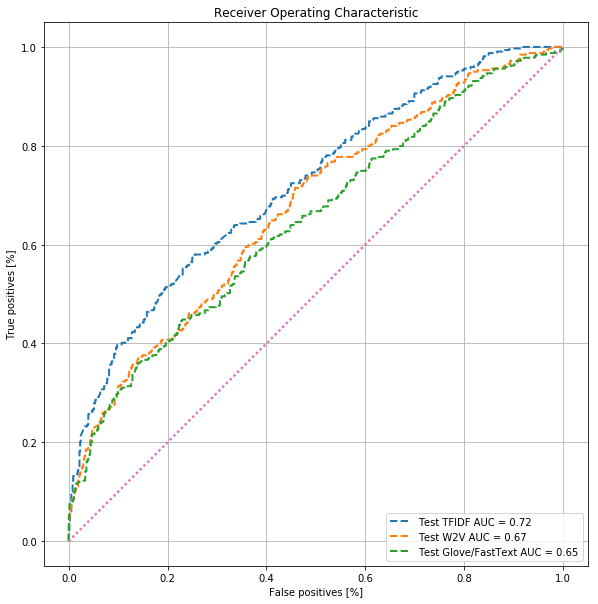

In [78]:
plot_roc("Test TFIDF", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

plot_roc("Test W2V", y_test_w2v, y_probas_test_w2v, color = colors[1], linestyle = '--')

plot_roc("Test Glove/FastText", y_test_gft, y_probas_test_gft, color = colors[2], linestyle = '--')